In [1]:
import os
import numpy as np
import nibabel as nib

from utils import calculate_dice_score
from em_algo import ExpectationMaximization

## Load Data

In [2]:
patient = 1

In [3]:
# Load the two NIfTI images
T1_path = f'data/{patient}/T1.nii'
T2_path = f'data/{patient}/T2_FLAIR.nii'
label_path = f'data/{patient}/LabelsForTesting.nii'
relative_save_path = f'results/mutilmodals/{patient}/'


### Load the images from the path
T1 = nib.load(T1_path)
T1_np_img = T1.get_fdata()
T2 = nib.load(T2_path)
T2_np_img = T2.get_fdata()
labels = nib.load(label_path)
labels_np_img = labels.get_fdata()

In [4]:
# Perform Skull Stripping to get the brain mask for WM, GM, and CSF
## Isolate the brain voxels using the label
#### Get the indices of the brain voxels
brain_voxels_indices = np.where(labels_np_img > 0)
#### Get the brain voxels from the T1 image using the indices get from the label
T1_skull_stripped = T1_np_img[brain_voxels_indices]
T2_skull_stripped = T2_np_img[brain_voxels_indices]

### Stack the T1 and T2 images to get the multi-modal image
X = np.vstack((T1_skull_stripped, T2_skull_stripped)).T

## EM Algorithm

In [5]:
## Min Max scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(X)

Iteration:  0  --- Log Likelihood:  10.906401627609464  --- Time (s):  0.12540411949157715


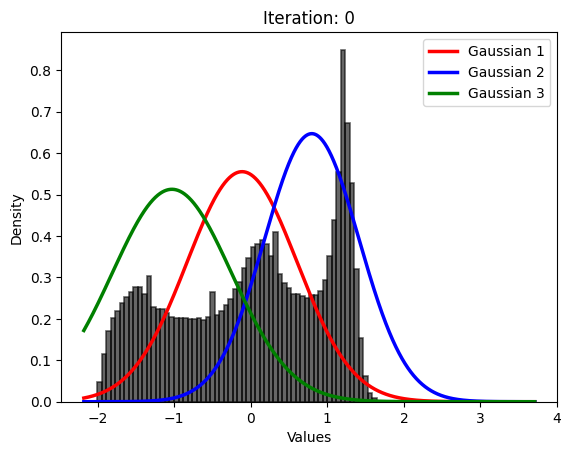

Iteration:  1  --- Log Likelihood:  11.180690694736679  --- Time (s):  0.08424782752990723
Iteration:  2  --- Log Likelihood:  11.318337772873981  --- Time (s):  0.0902557373046875
Iteration:  3  --- Log Likelihood:  11.360987945441737  --- Time (s):  0.0847618579864502
Iteration:  4  --- Log Likelihood:  11.373516503852564  --- Time (s):  0.08831119537353516
Iteration:  5  --- Log Likelihood:  11.37763008305861  --- Time (s):  0.12115716934204102
Iteration:  6  --- Log Likelihood:  11.379511608526046  --- Time (s):  0.08470988273620605
Iteration:  7  --- Log Likelihood:  11.38094599525405  --- Time (s):  0.08860111236572266
Iteration:  8  --- Log Likelihood:  11.38249685959855  --- Time (s):  0.0849771499633789
Iteration:  9  --- Log Likelihood:  11.384396454594915  --- Time (s):  0.08365225791931152
Iteration:  10  --- Log Likelihood:  11.386800129450453  --- Time (s):  0.08338594436645508
Iteration:  11  --- Log Likelihood:  11.389879053507888  --- Time (s):  0.08349084854125977
Ite

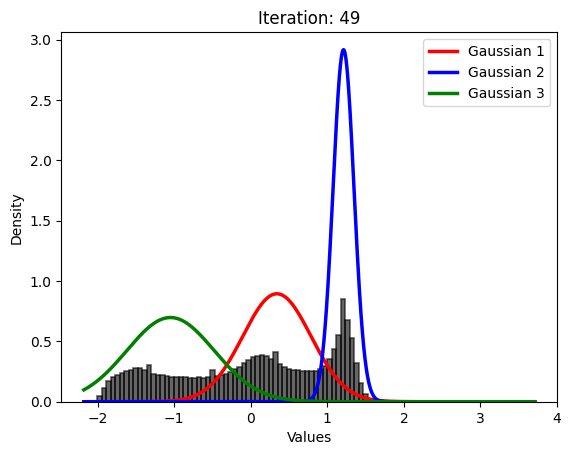

In [6]:
# Initialize the Expectation Maximization algorithm
em = ExpectationMaximization(X, k=3, max_iter=50, type='kmeans', plot_step=50, save_path=relative_save_path, show_plot=True, stop_criterion=1e-6)
alphas, mus, covars, W = em.fit()

## Postprocessing

Sort the means of the Gaussian components. This helps us map the classes to the intensity ranges.  
	•	The smallest mean will be assigned to CSF (1).  
	•	The middle mean will be assigned to GM (2).  
	•	The largest mean will be assigned to WM (3).  

In [7]:
# Assign each voxel to the cluster with the highest probability
voxel_assignments = np.argmax(W, axis=1)  # Get the index of the highest responsibility for each voxel
# Create a new 3D image with the same shape as the original brain image
segmented_image = np.zeros_like(T1_np_img)
# Map the voxel assignments back to the 3D segmented image using the brain_voxels_indices
segmented_image[brain_voxels_indices] = voxel_assignments + 1  # +1 to make the clusters 1, 2, 3

In [8]:
## 1 - CSF, 2 - GM, 3 - WM 
## Sort the clusters based on the mean intensity of the voxels in each cluster
sorted_mean_indices = np.argsort(np.mean(mus, axis=1)) + 1
## Assign the clusters to the correct class
class1_idx = np.where(segmented_image == sorted_mean_indices[0])
class2_idx = np.where(segmented_image == sorted_mean_indices[1])
class3_idx = np.where(segmented_image == sorted_mean_indices[2])
segmented_image[class1_idx] = 1
segmented_image[class2_idx] = 2
segmented_image[class3_idx] = 3

# Save the segmented image
segmented_img_nifti = nib.Nifti1Image(segmented_image, T1.affine)
nib.save(segmented_img_nifti, os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))

print("Segmented brain image saved as " + os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))

Segmented brain image saved as results/mutilmodals/1/segmented_brain_1.nii


## Evaluation

In [9]:
# Calculate the Dice score between the predicted labels and the ground truth
dice_scores = calculate_dice_score(label_path, os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))    
print(dice_scores)
print('Average Dice Score: ', np.mean(list(dice_scores.values())))

{1: 0.9069417683902804, 2: 0.8230784679386027, 3: 0.8523317394210499}
Average Dice Score:  0.8607839919166445
